# Animal Classification

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from tqdm import tqdm

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [2]:
data_dir = 'input/images'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 3023 images under train
Loaded 180 images under val
Loaded 353 images under test
Classes: 
['bobcat', 'chihuahua', 'collie', 'dalmatian', 'german_shepherd', 'leopard', 'lion', 'persian_cat', 'siamese_cat', 'tiger', 'wolf']


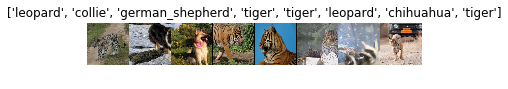

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [4]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in tqdm(enumerate(dataloaders[TEST])):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [14]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
    print(loss_test)
    print(acc_test)  

    avg_loss = loss_test.item() / dataset_sizes[TEST]
    avg_acc = acc_test.item() / dataset_sizes[TEST]

    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [6]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("input/vgg16bn/vgg16_bn.pth"))
print("Initial Out Features: {}".format(vgg16.classifier[6].out_features)) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print("End Out Features: {}".format(vgg16.classifier[6].out_features)) # 11 

# print(vgg16)

Initial Out Features: 1000
End Out Features: 11


In [7]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    try:
        vgg16.load_state_dict(torch.load('Output/Export.pt'))
        print("Loaded!")
    except: 
        print("NOT Loaded!")

In [8]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------


0it [00:00, ?it/s]

Test batch 0/45

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
45it [02:15,  2.27s/it]

tensor(113.0940)
tensor(42)

Evaluation completed in 2m 15s
Avg loss (test): 0.3204
Avg acc (test): 0.1190
----------


0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Ground truth:


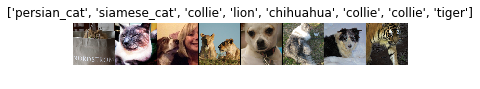

Prediction:


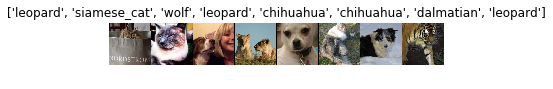

In [10]:
visualize_model(vgg16) #test before training

In [11]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in tqdm(enumerate(dataloaders[TRAIN])):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train.item() * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train.item() * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data[0]
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        avg_loss_val = loss_val.item() / dataset_sizes[VAL]
        avg_acc_val = acc_val.item() / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [12]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
torch.save(vgg16.state_dict(), 'Output/Model.pt')

Epoch 0/2
----------


0it [00:00, ?it/s]

Training batch 0/189.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100it [14:44,  8.77s/it]

Training batch 100/189.0

189it [27:42,  8.72s/it]


Validation batch 0/23

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch 0 result: 
Avg loss (train): 0.0991
Avg acc (train): 0.7403
Avg loss (val): 0.0292
Avg acc (val): 0.9222
----------

Epoch 1/2
----------



0it [00:00, ?it/s]

Training batch 0/189.0


1it [00:10, 10.59s/it]
2it [00:19, 10.10s/it]
3it [00:28,  9.83s/it]
4it [00:37,  9.55s/it]
5it [00:46,  9.28s/it]
6it [00:54,  9.06s/it]
7it [01:03,  8.93s/it]
8it [01:12,  8.82s/it]
9it [01:20,  8.80s/it]
10it [01:29,  8.75s/it]
11it [01:37,  8.68s/it]
12it [01:46,  8.62s/it]
13it [01:55,  8.63s/it]
14it [02:03,  8.65s/it]
15it [02:12,  8.61s/it]
16it [02:20,  8.60s/it]
17it [02:30,  8.81s/it]
18it [02:39,  9.00s/it]
19it [02:49,  9.18s/it]
20it [02:58,  9.26s/it]
21it [03:08,  9.42s/it]
22it [03:18,  9.47s/it]
23it [03:27,  9.50s/it]
24it [03:37,  9.48s/it]
25it [03:46,  9.48s/it]
26it [03:55,  9.46s/it]
27it [04:04,  9.23s/it]
28it [04:13,  9.05s/it]
29it [04:21,  8.94s/it]
30it [04:30,  8.85s/it]
31it [04:39,  8.86s/it]
32it [04:48,  8.81s/it]
33it [04:56,  8.82s/it]
34it [05:05,  8.84s/it]
35it [05:14,  8.77s/it]
36it [05:23,  8.77s/it]
37it [05:31,  8.75s/it]
38it [05:40,  8.70s/it]
39it [05:49,  8.75s/it]
40it [05:58,  8.77s/it]
41it [06:07,  8.84s/it]
42it [06:16,  8.90s/it]


Training batch 100/189.0


101it [15:03,  8.76s/it]
102it [15:12,  8.77s/it]
103it [15:20,  8.76s/it]
104it [15:29,  8.86s/it]
105it [15:40,  9.30s/it]
106it [15:50,  9.52s/it]
107it [15:59,  9.40s/it]
108it [16:07,  9.13s/it]
109it [16:16,  8.96s/it]
110it [16:24,  8.83s/it]
111it [16:33,  8.74s/it]
112it [16:42,  8.68s/it]
113it [16:50,  8.62s/it]
114it [16:59,  8.58s/it]
115it [17:07,  8.62s/it]
116it [17:16,  8.57s/it]
117it [17:24,  8.54s/it]
118it [17:33,  8.50s/it]
119it [17:41,  8.54s/it]
120it [17:50,  8.60s/it]
121it [17:59,  8.71s/it]
122it [18:08,  8.77s/it]
123it [18:17,  8.78s/it]
124it [18:25,  8.74s/it]
125it [18:34,  8.73s/it]
126it [18:43,  8.73s/it]
127it [18:51,  8.69s/it]
128it [19:00,  8.65s/it]
129it [19:09,  8.78s/it]
130it [19:18,  8.80s/it]
131it [19:27,  8.82s/it]
132it [19:35,  8.80s/it]
133it [19:44,  8.76s/it]
134it [19:53,  8.74s/it]
135it [20:02,  8.75s/it]
136it [20:10,  8.82s/it]
137it [20:19,  8.81s/it]
138it [20:28,  8.78s/it]
139it [20:37,  8.86s/it]
140it [20:47,  9.06s/it]


Validation batch 0/23
Epoch 1 result: 
Avg loss (train): 0.0574
Avg acc (train): 0.8468
Avg loss (val): 0.0269
Avg acc (val): 0.9389
----------


Training completed in 58m 10s
Best acc: 0.9389


Process Process-22:
Process Process-21:
Process Process-23:
Process Process-24:
Process Process-13:
Process Process-14:
Process Process-16:
Process Process-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run


  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
KeyboardInterrupt
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
KeyboardInterrupt
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/Library/Frameworks/Python.framework/Versions/

In [15]:
print("Test after training")
eval_model(vgg16, criterion)


Test after training
Evaluating model
----------
Test batch 0/45

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(10.4978)
tensor(328)

Evaluation completed in 2m 24s
Avg loss (test): 0.0297
Avg acc (test): 0.9292
----------





0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Ground truth:


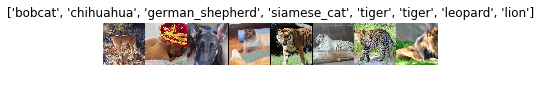

Prediction:


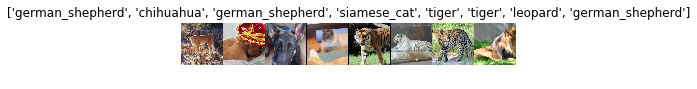




1it [00:03,  3.97s/it]

Ground truth:


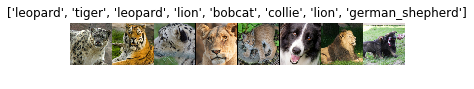

Prediction:


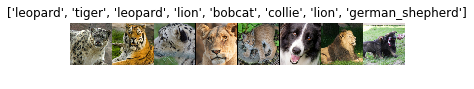




2it [00:07,  3.74s/it]

Ground truth:


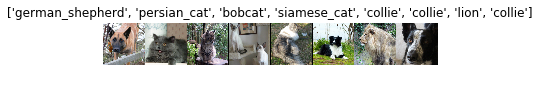

Prediction:


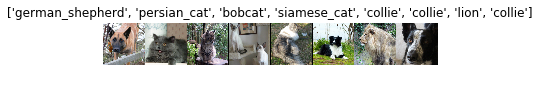




3it [00:10,  3.62s/it]

Ground truth:


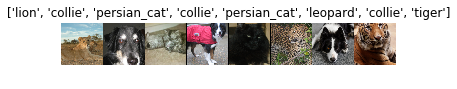

Prediction:


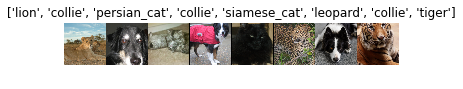

In [16]:
visualize_model(vgg16, num_images=32)


In [ ]:
# Train final model:
final_model_data = []
final_model_labels = []

for image_features in tqdm(train_features_from_pkl):
    bow_feature_vector = helpers.encodeImage(image_features.data,clustered_codebook)
    final_model_data.append(bow_feature_vector)
    try:
        final_model_labels.append(image_features.label.decode('utf-8'))
    except:
        final_model_labels.append(image_features.label)
final_model_labels = label_encoder.transform(final_model_labels)

In [10]:
clf = svm.SVC(kernel = 'linear', probability = True, max_iter = 10000,
              C = c, class_weight = 'balanced')
clf.fit(final_model_data, final_model_labels)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=10000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
# encode all test images 
test_data = []
for image_features in tqdm(test_features_from_pkl):
    bow_feature_vector = helpers.encodeImage(image_features.data,clustered_codebook)
    test_data.append(bow_feature_vector)

100%|██████████| 3550/3550 [00:27<00:00, 130.54it/s]


In [12]:
predictions = clf.predict_proba(test_data)

# Build a submission:
pred_file_path = os.path.join(PREDICTION_PATH, helpers.generateUniqueFilename('sift-linear','csv'))
helpers.writePredictionsToCsv(predictions,pred_file_path,label_strings)
